In [22]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import metrics

In [23]:
def load_dataframe_avg_urban_centers(training_data, split):
    con = sqlite3.connect("../data/global_urban_building_completeness.gpkg")
    query = f"""
        with agg_prediction as (
            select
              a.grid_fid
              ,a.urban_center_id
              ,'rf_adjusted' as model_name
              ,split
              ,avg(a.prediction) as prediction
            from performance_20_clusters_reference_and_osm as a 
            group by urban_center_id, grid_fid, split, model_name
        )
        select
          a.urban_center_id
          ,a.total_area_sqkm
          ,a.reference_osm_completeness
          ,a.region_wb
          ,b.model_name
          ,b.split
          ,SUM(b.prediction) as sum_prediction_sqkm
          ,case
                when a.osm_building_area_sqkm_2023 / SUM(b.prediction) < 0 then 0
                when a.osm_building_area_sqkm_2023 / SUM(b.prediction) > 1.5 then 1.5
                else a.osm_building_area_sqkm_2023 / SUM(b.prediction)
            end as prediction_osm_completeness
        from all_parameters_urban_centers a
        left join agg_prediction b
            on a.urban_center_id = b.urban_center_id
        where
            reference_building_area_sqkm is not null
            and
            reference_osm_completeness < 1.5
        group by
            a.urban_center_id
            ,reference_osm_completeness
            ,b.model_name
            ,a.osm_building_area_sqkm_2023
            ,b.split
            ,a.region_wb
            ,a.total_area_sqkm
    """
    df = pd.read_sql_query(query, con=con)
    df.dropna(inplace=True)
    print(f"got dataframe with {len(df)} samples.")    
    return df


def get_all_samples():
    con = sqlite3.connect("../data/global_urban_building_completeness.gpkg")
    query = f"""
        select 
          a.grid_fid as id
          ,a.urban_center_id
          ,a.region_wb 
        from all_parameters_urban_centers_grid a
    """
    df = pd.read_sql(query, con=con)
    print(f"got dataframe with {len(df)} samples from table: all_parameters_urban_centers_grid")
    return df

## Load Data

In [24]:
model_name = "rf_adjusted"
split = "cluster_20"
training_data = "reference_and_osm"

avg_prediction_df = load_dataframe_avg_urban_centers(
    training_data,
    split
)

df_all_samples = get_all_samples()

got dataframe with 7100 samples.
got dataframe with 665641 samples from table: all_parameters_urban_centers_grid


## Create Scatterplot for residuals for urban centers

871     0.923997
873     0.910769
932     0.788632
1271    1.064921
1276    0.796291
          ...   
4936    0.980044
4973    1.002822
5586    0.816176
5592    0.893555
5723    0.681008
Name: reference_osm_completeness, Length: 1103, dtype: float64 0.0 1.4742108581387925
871     0.869304
873     0.807974
932     0.876272
1271    1.086080
1276    0.898303
          ...   
4936    0.753335
4973    0.852527
5586    0.702781
5592    0.818545
5723    0.501858
Name: prediction_osm_completeness, Length: 1103, dtype: float64 0.0 1.5


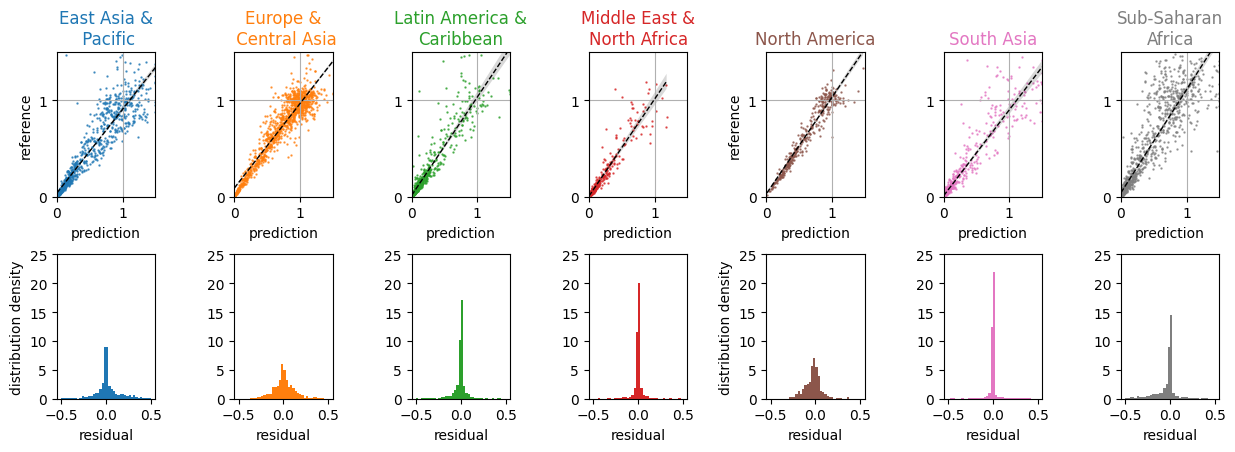

In [25]:
fig = plt.figure(figsize=(15, 4.5))
gs1 = gridspec.GridSpec(2, 7)
gs1.update(wspace=0.8, hspace=0.4) # set the spacing between axes.


titles = [
    "a)", "b)", "c)", "d)", "e)", "f)", "g)"
]

wb_regions_groups = [
    ["East Asia & Pacific"],
    ["Europe & Central Asia"],
    ["Latin America & Caribbean"],
    ["Middle East & North Africa"],
    ["North America"],
    ["South Asia"],
    ["Sub-Saharan Africa"],
]

label_strings = [
    "East Asia &\n Pacific",
    "Europe &\n Central Asia",
    "Latin America &\nCaribbean",
    "Middle East &\nNorth Africa",
    "North America",
    "South Asia",
    "Sub-Saharan\nAfrica",
    "all"
]

cmap = matplotlib.cm.get_cmap('tab10')
colors_dict = {
    "East Asia & Pacific": cmap(0),
    "Europe & Central Asia": cmap(0.125),
    "Latin America & Caribbean": cmap(0.25),
    "Middle East & North Africa": cmap(0.375),
    "North America": cmap(0.5),
    "South Asia": cmap(0.625),
    "Sub-Saharan Africa": cmap(0.75),
    "all": "black",
}

all_handles = []
all_labels = []

for i, wb_regions in enumerate(wb_regions_groups):
    y_test = avg_prediction_df.loc[
        (avg_prediction_df["region_wb"].isin(wb_regions))
        &
        (avg_prediction_df["model_name"] == model_name) 
    ]["reference_osm_completeness"]

    y_pred = avg_prediction_df.loc[
        avg_prediction_df["region_wb"].isin(wb_regions)
        &
        (avg_prediction_df["model_name"] == model_name)
    ]["prediction_osm_completeness"]
    
    weights = avg_prediction_df.loc[
        avg_prediction_df["region_wb"].isin(wb_regions)
        &
        (avg_prediction_df["model_name"] == model_name)
    ]["total_area_sqkm"]

    samples = len(df_all_samples.loc[
        df_all_samples["region_wb"].isin(wb_regions)
    ])
    
    if i == 1:
        print(y_test, min(y_test), max(y_test))
        print(y_pred, min(y_pred), max(y_pred))
    
    
    ax1 = plt.subplot(gs1[i])  # top
    ax2 = plt.subplot(gs1[i + 7])  # bottom
    
    limit = 0.6
    
    sns.regplot(
        x=y_pred,
        y=y_test,
        ax=ax1,
        scatter_kws={
            "s":0.5,
            "alpha":0.75,
            "color":colors_dict[wb_regions[0]]
        },
        line_kws={
            "linestyle":'--',
            "linewidth": 1.0,
            "color":"black"
        }
    )
    
    ax1.set_xlim([0, 1.5])
    ax1.set_xlabel("prediction")
        
    ax1.set_ylim([0.0, 1.5])
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels([0,1])
    ax1.grid()
    
    if i in [0, 4]:
        ax1.set_ylabel("reference")
    else:
        ax1.set_ylabel("")
    ax1.set_title(label_strings[i], color=colors_dict[wb_regions[0]])

    ax2.hist(
        y_pred - y_test,
        bins=40,
        #weights=weights,
        range=[-0.5, 0.5],
        density=True,
        color=colors_dict[wb_regions[0]],
        label=label_strings[i]
    )
    ax2.set_ylim([0, 25])
    if i in [0, 4]:
            ax2.set_ylabel("distribution density")
    else:
        ax2.set_ylabel("")
    ax2.set_xlabel("residual")
    
plt.savefig(
    f"../figures/performance_by_region_{model_name}_{split}_urban_centers.png",
    dpi=300,
    bbox_inches = 'tight',
    pad_inches = 0.25
)
plt.show()

## regional performance scores urban center level (for Table 5)

In [26]:
models = [
    "rf_adjusted",
]
splits = [
    "cluster_20",
]

score_names = [
    ['r2', metrics.r2_score],
    ['explained_variance', metrics.explained_variance_score],
    ['neg_mean_squared_error', metrics.mean_squared_error],
    ['neg_mean_absolute_error', metrics.mean_absolute_error],
]

training_data_sets = [
    "reference_and_osm"
]

wb_regions_groups = [
    ["Latin America & Caribbean"],
    ["East Asia & Pacific"],
    ["South Asia"],
    ["Europe & Central Asia"],
    ["North America"],
    ["Middle East & North Africa"],
    ["Sub-Saharan Africa"],
]

In [27]:
results_list = []
results = {}

for split in splits:
    results[split] = {}
    for training_data in training_data_sets:
        results[split][training_data] = {}
        avg_prediction_df = load_dataframe_avg_urban_centers(training_data, split)
        
        for model_name in models:
            print(model_name)
            results[split][training_data][model_name] = {}
            results[split][training_data][model_name]["samples"] = []
            results[split][training_data][model_name]["reference_samples"] = []
            for score_name, score_function in score_names:
                results[split][training_data][model_name][score_name] = []
            
            for i, wb_regions in enumerate(wb_regions_groups):
                y_test = avg_prediction_df.loc[
                    (avg_prediction_df["region_wb"].isin(wb_regions))
                    &
                    (avg_prediction_df["model_name"] == model_name) 
                ]["reference_osm_completeness"]

                y_pred = avg_prediction_df.loc[
                    avg_prediction_df["region_wb"].isin(wb_regions)
                    &
                    (avg_prediction_df["model_name"] == model_name)
                ]["prediction_osm_completeness"]
                
                weights = avg_prediction_df.loc[
                    avg_prediction_df["region_wb"].isin(wb_regions)
                    &
                    (avg_prediction_df["model_name"] == model_name)
                ]["total_area_sqkm"]
                
                if len(y_test) < 1:
                    print(f"no test samples for {wb_regions}")
                    continue
                
                samples = len(df_all_samples.loc[
                    df_all_samples["region_wb"].isin(wb_regions)
                ])
                
                reference_samples = len(y_test)
                
                results[split][training_data][model_name]["samples"].append(samples)
                results[split][training_data][model_name]["reference_samples"].append(reference_samples)

                for score_name, score in score_names:
                    val = score(
                        y_test,
                        y_pred,
                        #sample_weight=weights
                    )
                    results[split][training_data][model_name][score_name].append(val)

            # get weighted average global score
            list_item = [training_data, model_name, split]
            samples = results[split][training_data][model_name]["samples"]
            
            print(samples)
            print(sum(samples))
            
            reference_samples = results[split][training_data][model_name]["reference_samples"]
            print(reference_samples)
            print(sum(reference_samples))
            
            for score_name, score in score_names:
                vals = results[split][training_data][model_name][score_name]
                avg_score = np.average(
                    vals,
                    weights=samples
                )
                list_item.append(avg_score)
            results_list.append(list_item)
        
columns = [
    "training_data",
    "model_name",
    "split",
    "r2",
    "explained_variance",
    "MSE",
    "MAE"
]
list_df = pd.DataFrame(results_list, columns=columns)
display(list_df.sort_values("model_name", ascending=False))

got dataframe with 7100 samples.
rf_adjusted
[58953, 205921, 111578, 94003, 103621, 39154, 52411]
665641
[874, 975, 1660, 1103, 367, 663, 1458]
7100


,training_data,model_name,split,r2,explained_variance,MSE,MAE
0,reference_and_osm,rf_adjusted,cluster_20,0.869046,0.872815,0.015953,0.067517


In [28]:
for split in splits:
    for model_name in [
        "rf_adjusted",
    ]:
        results_list_regions = []
        for i, wb_region in enumerate(wb_regions_groups):
            results_list_regions.append([
                model_name,
                wb_region,
                split,
                results[split]["reference_and_osm"][model_name]["samples"][i],
                results[split]["reference_and_osm"][model_name]["reference_samples"][i],
                results[split]["reference_and_osm"][model_name]["r2"][i],
                results[split]["reference_and_osm"][model_name]["explained_variance"][i],
                results[split]["reference_and_osm"][model_name]["neg_mean_squared_error"][i],
                results[split]["reference_and_osm"][model_name]["neg_mean_absolute_error"][i],
            ])


        columns = [
            "model_name",
            "region",
            "split",
            "samples",
            "reference_samples",
            "r2",
            "explained_variance",
            "MSE",
            "MAE"
        ]
        list_df = pd.DataFrame(results_list_regions, columns=columns)
        display(list_df.sort_values("region", ascending=True))

,model_name,region,split,samples,reference_samples,r2,explained_variance,MSE,MAE
1,rf_adjusted,[East Asia & Pacific],cluster_20,205921,975,0.854569,0.856935,0.022679,0.087272
3,rf_adjusted,[Europe & Central Asia],cluster_20,94003,1103,0.848873,0.848887,0.016413,0.090919
0,rf_adjusted,[Latin America & Caribbean],cluster_20,58953,874,0.872752,0.875440,0.011110,0.044596
5,rf_adjusted,[Middle East & North Africa],cluster_20,39154,663,0.903449,0.903895,0.004754,0.024718
4,rf_adjusted,[North America],cluster_20,103621,367,0.913887,0.922110,0.009142,0.068289
2,rf_adjusted,[South Asia],cluster_20,111578,1660,0.879346,0.879509,0.007422,0.025820
6,rf_adjusted,[Sub-Saharan Africa],cluster_20,52411,1458,0.821653,0.840246,0.034149,0.092921
